In [1]:
# from dotenv import load_dotenv

# load_dotenv()

import pandas as pd
from typing import List
# from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import describe
from thefuzz import fuzz
from copy import deepcopy


from knowledge_propagation.modules.evaluators import (
    ExactMatchEvaluator,
    RougeEvaluator,
    OpenAIEvaluator,
)

from collections import defaultdict

llm_evaluator = OpenAIEvaluator()

def macro_averaging(df: pd.DataFrame, metrics: List[str], multi_level_averaging: List[str]):
    """
    Do macro-averaging over the given metrics and multi-level averaging categories.
    """
    extracted_multi_level_cols = [[m, "mean"] for m in metrics]
    while len(multi_level_averaging) > 0:
        # first take the mean over each generation,
        # and, only take `mean` of `rouge1` and  `llm_accuracy` column groups
        df_over_cols = df.groupby(multi_level_averaging, observed=True).describe()[extracted_multi_level_cols]
        # remove the multi-level column indices, since there's only one sub-level -- "mean"
        df_over_cols.columns = df_over_cols.columns.get_level_values(0)

        # reset index to flatten the multi-level column indices for the next macro-averaging class
        df = df_over_cols.reset_index(inplace=False)
        multi_level_averaging.pop(-1)
    return df
os.getcwd()

'/datastor1/zliu/mend/notebooks'

In [2]:


# df = pd.read_excel(f"{os.getenv('PROJ_PLAYGROUND')}/mend/ripple_exp_output/llama3.2-1B-eos-sft/all/base_n=500_prompt=no_w-gen_wo-icl_ice=True.xlsx")
df = pd.read_excel(f"/u/zliu/datastor1/mend/ripple_exp_output/llama3.2-1B-eos-sft-estimated/ripple_edits/memit(ripple_all)_eval_loss=clm_input=seen_n=500_prompt=no_w-gen_wo-icl_e+s_all-question.xlsx")
print("Num of rows:", len(df))
df.describe()[[ "exact_match", "llm_accuracy",]].round(2) # 
pre_edit_df = df[df["stage"] == "pre-edit"]
post_edit_df = df[df["stage"] == "post-edit"]
len(post_edit_df)

Num of rows: 5223


5223

In [3]:
# df.head()

In [4]:
base_df = pd.read_excel(f"{os.getenv('PROJ_PLAYGROUND')}/mend/ripple_exp_output/llama3.2-1B-eos-sft/all/base_n=500_prompt=no_w-gen_wo-icl_ice=True.xlsx")
print("Num of rows:", len(df))

Num of rows: 5223


In [5]:
# macro_avg_df = macro_averaging(post_edit_df, multi_level_averaging=["question_tag", "id"], metrics=["exact_match", "llm_accuracy",]).round(2) 

# macro_avg_df.question_tag = pd.Categorical(
#     macro_avg_df.question_tag,
#     categories=[
#         "efficacy_Logical_Generalization","efficacy_Compositionality_I","efficacy_Compositionality_II","efficacy_Subject_Aliasing", "specificity_Relation_Specificity", "specificity_Forgetfulness"
#     ],
#     ordered=True
# )
# macro_avg_df.sort_values(by=["question_tag",], inplace=False)

In [6]:
# df = post_edit_df
for tag in [
        "efficacy_Logical_Generalization","efficacy_Compositionality_I","efficacy_Compositionality_II","efficacy_Subject_Aliasing", "specificity_Relation_Specificity", "specificity_Forgetfulness"
    ]:
    agg = df[df["question_tag"] == tag].describe()[["llm_accuracy",]]
    print(tag, f"(n={agg['llm_accuracy']['count']})")
    
    print(agg['llm_accuracy']['mean'].round(2)) #
    print()

efficacy_Logical_Generalization (n=230.0)
0.13

efficacy_Compositionality_I (n=1679.0)
0.15

efficacy_Compositionality_II (n=273.0)
0.14

efficacy_Subject_Aliasing (n=777.0)
0.25

specificity_Relation_Specificity (n=1982.0)
0.23

specificity_Forgetfulness (n=282.0)
0.07



In [7]:
# verbtaim_queries = [tuple([x[0], x[1], x[2]]) for x in io.load_json(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/llm_acc_verbtaim_queries.json")]
verbtaim_queries = [tuple([x[0], x[1], x[2]]) for x in io.load_json(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/em_verbatim_queries_eff+spec.json")]
# non_verbtaim_queries = io.load_json(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/llm_acc_nonverbtaim_queries.json")
len(verbtaim_queries)

1538

In [8]:
ripple_edits_examples = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/test_aug.jsonl")
non_zero_outerloop_count = 0
strong_meta_examples = []
weak_meta_examples = []
queries = []
for e_i, example in enumerate(ripple_edits_examples):
    efficacy_queries = []
    # non_zero_outerloop_count += len(outerloop_instances) > 0
    for k in ["Logical_Generalization", "Compositionality_I", "Compositionality_II", "Subject_Aliasing"]:
        for instance in example[k]:
            for q in instance["test_queries"]:
                if (
                    len(q["answers"]) > 0
                    and len([a["value"] for a in q["answers"] if len(a["value"].strip()) > 0]) > 0
                ):
                    q["question_type"] = k
                    # q["answers"] = [a["value"] for a in q["answers"] if len(a["value"].strip()) > 0]
                    q["answers"] = [x  for a in q["answers"] for x in [a["value"]] + a["aliases"] if len(a["value"].strip()) > 0]
                    
                    efficacy_queries.append(q)
    queries.extend(efficacy_queries)
    assert len(efficacy_queries) > 0

    specificity_queries = []
    for k in ["Relation_Specificity", "Forgetfulness"]:
        for instance in example[k]:
            for q in instance["test_queries"]:
                if (
                    len(q["answers"]) > 0
                    and len([a["value"] for a in q["answers"] if len(a["value"].strip()) > 0]) > 0
                ):
                    q["question_type"] = k
                    # q["answers"] = [a["value"] for a in q["answers"] if len(a["value"].strip()) > 0]
                    q["answers"] = [x for a in q["answers"] for x in [a["value"]] + a["aliases"] if len(a["value"].strip()) > 0]
                    specificity_queries.append(q)
    queries.extend(specificity_queries)
    

In [9]:
df.head(2)

,id,question_type,question_tag,relation,edit_input,stage,question,answer,predicted_answer_idx,predicted_answer,exact_match,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy
0,0,efficacy,efficacy_Compositionality_II,COUNTRY,The name of the continent which United Arab Em...,post-edit,The name of the continent which the country St...,Indian Ocean,0,Iran,0,0,0.666667,0,0.363636,0.0
1,0,efficacy,efficacy_Compositionality_II,COUNTRY,The name of the continent which United Arab Em...,post-edit,The name of the continent which the country Gu...,Indian Ocean,0,the Indian Ocean,0,0,0.666667,0,0.333333,1.0


In [10]:
bos = "<|begin_of_text|>"
eos = "<|end_of_text|>"
edit_column_name = "edit_input"
# below is for ICE and base
# bos = "[[" 
# eos = "]]"
# edit_column_name = "input"

In [11]:
ice = False
original_mend = False
memit = True

In [12]:
# question2answers = {}
# dup = []
# for q in tqdm(queries):
#     if q["prompt"] not in question2answers:
#         question2answers[q["prompt"]] = q["answers"]
#     else:
#         question2answers[q["prompt"]] = list(set(question2answers[q["prompt"]] + q["answers"]))
#         dup.append(q["prompt"])
#         # assert question2answers[q["prompt"]] == q["answers"], q["answers"] # question2answers[q["prompt"]]
#     # question2answers[q["question"]] = [a for a in q["answers"] if len(a.strip()) > 0]
#     # assert len(question2answers[q["question"]]) > 0

In [13]:
efficacy_df = df[(df["question_type"] == "efficacy")] #  & (df["question_tag"] == "efficacy_Logical_Generalization")]

print("# efficacy:", len(efficacy_df))

# new_df_content = []
verbtaim_df_content = []
non_verbtaim_df_content = []
for r_i, r in efficacy_df.iterrows():
    # if r["question_type"] == "specificity":
        # continue
    prop_type = r["question_tag"].replace(r["question_type"] + "_", "")
    
    if bos in r[edit_column_name] and eos in r[edit_column_name]:
        edit_input = r[edit_column_name][r[edit_column_name].index(bos) + len(bos):r[edit_column_name].index(eos)]
    else:
        edit_input = r[edit_column_name]
    if original_mend:
        edit_input += "."
    
    if ice:
        question = r["question"]
        icl_edit = "Imagine that " + edit_input[0].lower() + edit_input[1:]
        assert icl_edit in question, question
        question = question.replace(icl_edit, "", 1).strip()
        
    else:
        question = r["question"]
    
    assert question == queries[r_i]["prompt"], r_i
    answer_full_sent = queries[r_i]["prompt"] + " " + str(r["predicted_answer"])
    r["rippleedit_exact_match"] = float(any(a in answer_full_sent for a in queries[r_i]["answers"]))
    # new_df_content.append(r)
    if (edit_input, prop_type, question) not in verbtaim_queries:
        non_verbtaim_df_content.append(r)
        continue
    # assert r["answer"] in edit_input, r
    # if r["answer"] not in edit_input:
    if not any(a in edit_input for a in queries[r_i]["answers"]):
        non_verbtaim_df_content.append(r)
        continue
    verbtaim_df_content.append(r)

verbtaim_df = pd.DataFrame(verbtaim_df_content)
non_verbtaim_df = pd.DataFrame(non_verbtaim_df_content)
print("# verbtaim:", len(verbtaim_df))
print("# non-verbtaim:", len(non_verbtaim_df))

# efficacy: 2959
# verbtaim: 1372
# non-verbtaim: 1587


In [16]:
print("verbtaim efficacy (llm_acc): ",  (verbtaim_df.describe()["llm_accuracy"]["mean"] * 100).round(1))
print("non-verbtaim efficacy (llm_acc): ",  (non_verbtaim_df.describe()["llm_accuracy"]["mean"] * 100) .round(1))

verbtaim efficacy (llm_acc):  22.5
non-verbtaim efficacy (llm_acc):  12.7


In [17]:
specificity_df = df[(df["question_type"] == "specificity")] #  & (df["question_tag"] == "efficacy_Logical_Generalization")]

print("# specificity:", len(specificity_df))

# new_df_content = []
verbtaim_spec_df_content = []
non_verbtaim_spec_df_content = []
for r_i, r in specificity_df.iterrows():
    # if r["question_type"] == "specificity":
        # continue
    prop_type = r["question_tag"].replace(r["question_type"] + "_", "")
    
    if bos in r[edit_column_name]:
        edit_input = r[edit_column_name][r[edit_column_name].index(bos) + len(bos):r[edit_column_name].index(eos)]
    else:
        edit_input = r[edit_column_name]
    if original_mend:
        edit_input += "."
    
    if ice:
        question = r["question"]
        icl_edit = "Imagine that " + edit_input[0].lower() + edit_input[1:]
        assert icl_edit in question, question
        question = question.replace(icl_edit, "", 1).strip()
        
    else:
        question = r["question"]
    
    assert question == queries[r_i]["prompt"], r_i
    answer_full_sent = queries[r_i]["prompt"] + " " + str(r["predicted_answer"])
    r["rippleedit_exact_match"] = float(any(a in answer_full_sent for a in queries[r_i]["answers"]))
    # new_df_content.append(r)
    if (edit_input, prop_type, question) not in verbtaim_queries:
        non_verbtaim_spec_df_content.append(r)
        continue
    # assert r["answer"] in edit_input, r
    # if r["answer"] not in edit_input:
    if not any(a in edit_input for a in queries[r_i]["answers"]):
        non_verbtaim_spec_df_content.append(r)
        continue
    verbtaim_spec_df_content.append(r)

verbtaim_spec_df = pd.DataFrame(verbtaim_spec_df_content)
non_verbtaim_spec_df = pd.DataFrame(non_verbtaim_spec_df_content)
print("# verbtaim:", len(verbtaim_spec_df))
print("# non-verbtaim:", len(non_verbtaim_spec_df))

# specificity: 2264
# verbtaim: 164
# non-verbtaim: 2100


In [18]:
print("verbtaim specificity (llm_acc): ",  (verbtaim_spec_df.describe()["llm_accuracy"]["mean"] * 100).round(1))
print("non-verbtaim specificity (llm_acc): ",  (non_verbtaim_spec_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

verbtaim specificity (llm_acc):  22.0
non-verbtaim specificity (llm_acc):  21.4


In [58]:
2264 + 2959

5223

verbtaim efficacy (llm_acc):  0.65
non-verbtaim efficacy (llm_acc):  0.08


In [863]:
print("verbtaim efficacy (RE_exact_match): ",  verbtaim_df.describe()["rippleedit_exact_match"]["mean"].round(2))
print("non-verbtaim efficacy (RE_exact_match): ",  non_verbtaim_df.describe()["rippleedit_exact_match"]["mean"].round(2))

verbtaim efficacy (RE_exact_match):  0.77
non-verbtaim efficacy (RE_exact_match):  0.18


### Calculate EM in RippleEdits' fashion

In [852]:
new_df_content = []

for r_i, r in df.iterrows():
    new_r = deepcopy(r)
    if bos in r[edit_column_name]:
        edit_input = r[edit_column_name][r[edit_column_name].index(bos) + len(bos):r[edit_column_name].index(eos)]
    else:
        edit_input = r[edit_column_name]
    if original_mend:
        edit_input += "."
    if ice:
        question = r["question"]
        icl_edit = "Imagine that " + edit_input[0].lower() + edit_input[1:]
        assert icl_edit in question, r
        question = question.replace(icl_edit, "", 1).strip()
    else:
        question = r["question"]
    assert question == queries[r_i]["prompt"]
    answer_full_sent = queries[r_i]["prompt"] + " " + str(r["predicted_answer"])
    new_r["rippleedit_exact_match"] = float(any(a in answer_full_sent for a in queries[r_i]["answers"]))
    new_df_content.append(new_r)
new_df = pd.DataFrame(new_df_content)

In [853]:
df = new_df
for tag in [
        "efficacy_Logical_Generalization","efficacy_Compositionality_I","efficacy_Compositionality_II","efficacy_Subject_Aliasing", "specificity_Relation_Specificity", "specificity_Forgetfulness"
    ]:
    agg = df[df["question_tag"] == tag].describe()[["rippleedit_exact_match",]]
    print(tag, f"(n={agg['rippleedit_exact_match']['count']})")
    
    print(agg['rippleedit_exact_match']['mean'].round(2)) #
    print()

efficacy_Logical_Generalization (n=230.0)
0.13

efficacy_Compositionality_I (n=1679.0)
0.13

efficacy_Compositionality_II (n=273.0)
0.11

efficacy_Subject_Aliasing (n=777.0)
0.16

specificity_Relation_Specificity (n=1982.0)
0.24

specificity_Forgetfulness (n=282.0)
0.51



In [639]:
print("verbtaim efficacy (em): ",  verbtaim_df.describe()["exact_match"]["mean"].round(2))
print("non-verbtaim efficacy (em): ",  non_verbtaim_df.describe()["exact_match"]["mean"].round(2))

verbtaim efficacy (em):  0.62
non-verbtaim efficacy (em):  0.02


In [640]:
efficacy_df[efficacy_df["question_tag"] == "efficacy_Logical_Generalization"].describe()[["exact_match", "llm_accuracy"]].round(2)

,exact_match,llm_accuracy
count,230.00,230.00
mean,0.05,0.13
std,0.21,0.30
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,1.00,1.00


In [47]:
new_df.describe()[["rippleedit_exact_match", "llm_accuracy"]].round(2)

,rippleedit_exact_match,llm_accuracy
count,5223.00,5223.00
mean,0.42,0.43
std,0.49,0.47
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,1.00,1.00
max,1.00,1.00


In [ ]:
new_df[new_df["question_tag"] == tag].describe()

,id,predicted_answer_idx,exact_match,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy,rippleedit_exact_match
count,230.000000,230.0,230.000000,230.000000,230.000000,230.0,230.000000,230.000000,230.000000
mean,215.743478,0.0,0.165217,0.165217,0.684288,0.0,0.550853,0.280870,0.343478
std,135.497399,0.0,0.372187,0.372187,0.213155,0.0,0.107979,0.429562,0.475905
min,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.266667,0.000000,0.000000
25%,108.000000,0.0,0.000000,0.000000,0.500000,0.0,0.476708,0.000000,0.000000
50%,178.000000,0.0,0.000000,0.000000,0.666667,0.0,0.545455,0.000000,0.000000
75%,325.500000,0.0,0.000000,0.000000,0.833333,0.0,0.635167,0.700000,1.000000
max,496.000000,0.0,1.000000,1.000000,1.000000,0.0,0.785714,1.000000,1.000000


In [52]:
df = new_df
for tag in [
        "efficacy_Logical_Generalization","efficacy_Compositionality_I","efficacy_Compositionality_II","efficacy_Subject_Aliasing", "specificity_Relation_Specificity", "specificity_Forgetfulness"
    ]:
    agg = df[df["question_tag"] == tag].describe()[["rippleedit_exact_match"]]
    print(tag, f"(n={agg['rippleedit_exact_match']['count']})")
    
    # print("llm_accuracy:", agg['llm_accuracy']['mean'].round(2)) #
    print("rippleedit_exact_match:", agg['rippleedit_exact_match']['mean'].round(2)) #
    print()

efficacy_Logical_Generalization (n=230.0)
rippleedit_exact_match: 0.34

efficacy_Compositionality_I (n=1679.0)
rippleedit_exact_match: 0.24

efficacy_Compositionality_II (n=273.0)
rippleedit_exact_match: 0.85

efficacy_Subject_Aliasing (n=777.0)
rippleedit_exact_match: 0.79

specificity_Relation_Specificity (n=1982.0)
rippleedit_exact_match: 0.34

specificity_Forgetfulness (n=282.0)
rippleedit_exact_match: 0.67



In [74]:
# len(pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/ripple_edits_all_recent+popular_heavy-noshare-mid-upper3/ripple_edits/mend_eval_loss=clm_input=seen_n=300_prompt=no_w-gen_wo-icl_e+s_all_wo_random-question.xlsx"))

In [75]:
# df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/ripple_edits_all_original_mend_share_top3/ripple_edits/mend_eval_loss=sft_input=seen_n=500_prompt=no_w-gen_wo-icl_e+s_all-question.xlsx")
test_data = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/test_wo_random.jsonl")
test_wo_random_df_content = []
for t in test_data:
    for edit_input, sub_df in df.groupby("edit_input"):
        # if t["edit"]["prompt"] == edit_input:
        if t["edit"]["prompt"].strip()[:-1] in edit_input:
            test_wo_random_df_content.append(sub_df)
            break
test_wo_random_df = pd.concat(test_wo_random_df_content)

In [89]:
# len(test_wo_random_df)
# non_verbtaim_df

verbtaim efficacy:  0.83
non-verbtaim efficacy:  0.09


,question_tag,exact_match,llm_accuracy
2,efficacy_Logical_Generalization,0.04,0.14
0,efficacy_Compositionality_I,0.51,0.60
1,efficacy_Compositionality_II,0.76,0.80
3,efficacy_Subject_Aliasing,0.75,0.78


In [18]:
save_dir = "/u/zliu/datastor1/mend/ripple_exp_output/Llama-3.2-1B-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tuned-params=midupper3-mlp/individual_results_all"
all_df = pd.concat([pd.read_excel(f) for f in glob(f"{save_dir}/*.xlsx", recursive=True)])
len(all_df)

5223

In [50]:
test_data = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/test.jsonl")
test_data_aug = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/test_aug.jsonl")

In [ ]:
test_data_aug[257]["edit"]["prompt"]

'The name of the screenwriter of The bomb : the weapon that changed the world is Laurent-Frédéric Bollée.'

In [54]:
test_data[257]["edit"]["prompt"]

'The name of the screenwriter of  is Laurent-Frédéric Bollée.'

In [52]:
[i for i, d in enumerate(test_data) if d["edit"]["prompt"] != test_data_aug[i]["edit"]["prompt"] ]

[257]

In [46]:
ice_df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/llama3.2-1B-eos-sft/all/base_n=500_prompt=no_w-gen_wo-icl_ice=True.xlsx")

knowprop_df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/ripple_edits_all_heavy-noshare-mid-upper3_all-in-outer/ripple_edits/mend_eval_loss=clm_input=seen_n=500_prompt=no_w-gen_wo-icl_e+s_all-question.xlsx")

In [47]:
len(ice_df) == len(knowprop_df)

True

In [891]:
spotcheck_df = pd.concat([cpt_df, knowprop_df, knowprop_best_df])

In [ ]:
spotcheck_df = spotcheck_df.sort_values(by=["id", "question_tag", "question", "verbatim" "Method"])

In [893]:
spotcheck_df = spotcheck_df.set_index(["id", "question_tag", "question", "Method"], inplace=False)

In [888]:
spotcheck_df.to_excel("/u/zliu/datastor1/mend/spotcheck/spotcheck_results.xlsx", index=True)

In [58]:
for i, ice_r in ice_df.iterrows():
    knowprop_r = knowprop_df.iloc[i]
    if ice_r["llm_accuracy"] > knowprop_r["llm_accuracy"]:
        print(i)
        print("Input: ", ice_r["input"])
        print("Question: ", ice_r["question"])
        print("Question Tag: ", ice_r["question_tag"])
        
        print("Answer: ", ice_r["answer"])
        print(f"ICE Output ({ice_r['llm_accuracy']}): ", ice_r["predicted_answer"])
        print(f"KnowProp Output ({knowprop_r['llm_accuracy']}): ", knowprop_r["predicted_answer"])
        print("==="*20)

22
Input:  [[The name of the continent which United Arab Emirates is part of is Indian Ocean.]]
Question:  Imagine that the name of the continent which United Arab Emirates is part of is Indian Ocean. The name of the currency in United Arab Emirates is
Question Tag:  specificity_Relation_Specificity
Answer:  United Arab Emirates dirham
ICE Output (1.0):  DIRHAM
KnowProp Output (0.0):  Indian rupee
23
Input:  [[The name of the continent which United Arab Emirates is part of is Indian Ocean.]]
Question:  Imagine that the name of the continent which United Arab Emirates is part of is Indian Ocean. The official language of United Arab Emirates is
Question Tag:  specificity_Relation_Specificity
Answer:  Arabic
ICE Output (1.0):  Arabic
KnowProp Output (0.0):  English
28
Input:  [[The name of the spouse of Osman I is Elna Kiljander.]]
Question:  Imagine that the name of the spouse of Osman I is Elna Kiljander. The name of the country of citizenship of the spouse of Osman I is
Question Tag:  

In [53]:
knowprop_r

id                                                                    499
question_type                                                 specificity
question_tag                                    specificity_Forgetfulness
relation                                                      CAST_MEMBER
edit_input              [[<|begin_of_text|>The names of the cast membe...
stage                                                           post-edit
question                The names of the cast members of The 34th Batt...
answer                                                    Emilie de Ravin
predicted_answer_idx                                                    0
predicted_answer                                       The 34th Battalion
exact_match                                                             0
is_num                                                              False
abs_diff                                                              NaN
diff                                  

In [ ]:
# test_data = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/all/test_wo_random.jsonl")

In [ ]:
# new_df_content = []

# for instance_id, sub_df in df.groupby("id"):
#     test_datum  = test_data[instance_id]
#     sub_df.insert(0, "edit_input", test_datum["edit"]["prompt"])
#     new_df_content.append(sub_df)
# new_df = pd.concat(new_df_content)
    

In [41]:
# new_df[new_df["id"] == 257]

In [2]:
df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/Llama-3.2-1B-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tuned-params=midupper3-mlp/all_results_ALL_with_input.xlsx", index=False)

NameError: name 'pd' is not defined

In [34]:
df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/Llama-3.2-1B-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tuned-params=all/all_results_ALL_with_input.xlsx")
df[df["id"] == 257]

,edit_input,id,question_type,question_tag,relation,stage,question,answer,predicted_answer_idx,predicted_answer,exact_match,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy
3420,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The place of birth of the screenwriter of is,Orléans,0,New York,0,0,0.600000,0,0.500000,0.0
3421,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The name of the alma mater of the screenwriter...,Panthéon-Assas University,0,The Rose of Sharon,0,0,0.500000,0,0.523810,0.0
3422,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The name of the country of citizenship of the ...,France,0,France,1,1,1.000000,0,0.500000,1.0
3423,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The gender of the screenwriter of is,male,0,male,1,1,1.000000,0,0.363636,1.0
3424,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The occupation of the screenwriter of is,journalist,0,a profession,0,0,0.500000,0,0.272727,0.0
3425,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The occupation of the screenwriter of is,comics writer,0,a profession,0,0,0.333333,0,0.250000,0.0
3426,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The occupation of the screenwriter of is,editor-in-chief,0,a profession,0,0,0.500000,0,0.307692,0.0
3427,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The name of the award the screenwriter of won is,Amerigo Vespucci prize,0,the PEN/Faulkner Award,0,0,0.714286,0,0.526316,0.0
3428,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The name of the position held by the screenwri...,editor-in-chief,0,Executive Producer,0,0,0.500000,0,0.529412,0.0
3429,The name of the screenwriter of The bomb : the...,257,efficacy,efficacy_Compositionality_I,SCREENWRITER,post-edit,The name of the field of work of the screenwri...,comics,0,Film,0,0,0.500000,0,0.500000,0.3


In [7]:
# all_df.to_excel(f"{save_dir}/../all_results_ALL.xlsx", index=False)

In [66]:
# [["question", "predicted_answer", "answer"]]
for _, row in post_edit_df[post_edit_df["question_tag"] == "efficacy_Subject_Aliasing"].iterrows():
    print(row["question"])
    print(row["predicted_answer"])
    print(row["answer"])
    print() 

The name of the league which Kevin Grosskreutz plays in is
3. Liga.
3. Liga

The name of the editor of Consuetudines feudorum is
Iacopo d'Ardizzone
Iacopo d'Ardizzone

The name of the child of Jack Leonard Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of Jack Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of J. L. Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of J L Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of J. Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of J Strominger is
Andrew Strominger.
Andrew Strominger

The name of the child of Strominger is
Strominger
Andrew Strominger

The name of the child of Strominger J is
Strominger J
Andrew Strominger

The name of the child of Strominger J. is
Strominger J.
Andrew Strominger

The name of the child of Strominger J. L. is
Strominger J. L.
Andrew Strominger

The name of the child of Strominger JL 

In [21]:
df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/llama3.2-1B-eos-sft/all_propagation/base_n=200_prompt=no_w-gen_wo-icl_ice=True.xlsx")
print("Num of rows:", len(df))
# df.describe()[["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy",]].round(2)
for _, row in df[df["question_tag"] == "efficacy_Compositionality_II"].iterrows():
    print(row["question"])
    print(row["predicted_answer"])
    print(row["answer"])
    print() 


Num of rows: 2566
Imagine that the occupation of Brian May is art gallery. The occupation of the spouse of Anita Dobson is
PR
art gallery

Imagine that the name of the child of Jean-Claude Cotillard is Marion Cotillard. The name of the child of the father of Marion Cotillard is
Sebastian
Marion Cotillard

Imagine that the place of death of Emily Post is New York City. The place of death of the mother of Edwin M. Post, Jr. is
New York City
New York City

Imagine that the eye color of Mary Margaret Blanchard is hazel. The eye color of the mother of Emma Swan-Jones is
brown
hazel

Imagine that the eye color of Mary Margaret Blanchard is hazel. The eye color of the mother of Neal Nolan is
brown
hazel

Imagine that the name of the child of Emma Maria Fischer is Heinz Fischer. The name of the child of the mother of Edith Stumpf-Fischer is
Helmut
Heinz Fischer

Imagine that the name of the child of Emma Maria Fischer is Heinz Fischer. The name of the child of the mother of Heinz Fischer is
Ma

In [22]:
base_df = pd.read_excel("/u/zliu/datastor1/mend/ripple_exp_output/llama3.2-1B-eos-sft/all_propagation/base_n=200_prompt=no_w-gen_wo-icl_ice=True.xlsx")
print("Num of rows:", len(base_df))
# df.describe()[["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy",]].round(2)
for _, row in base_df[base_df["question_tag"] == "efficacy_Compositionality_II"].iterrows():
    print(row["question"])
    print(row["predicted_answer"])
    print(row["answer"])
    print() 


Num of rows: 2566
Imagine that the occupation of Brian May is art gallery. The occupation of the spouse of Anita Dobson is
PR
art gallery

Imagine that the name of the child of Jean-Claude Cotillard is Marion Cotillard. The name of the child of the father of Marion Cotillard is
Sebastian
Marion Cotillard

Imagine that the place of death of Emily Post is New York City. The place of death of the mother of Edwin M. Post, Jr. is
New York City
New York City

Imagine that the eye color of Mary Margaret Blanchard is hazel. The eye color of the mother of Emma Swan-Jones is
brown
hazel

Imagine that the eye color of Mary Margaret Blanchard is hazel. The eye color of the mother of Neal Nolan is
brown
hazel

Imagine that the name of the child of Emma Maria Fischer is Heinz Fischer. The name of the child of the mother of Edith Stumpf-Fischer is
Helmut
Heinz Fischer

Imagine that the name of the child of Emma Maria Fischer is Heinz Fischer. The name of the child of the mother of Heinz Fischer is
Ma

In [ ]:
# all_df.to_excel(f"{save_dir}/../all_results_ripple.xlsx", index=False)

In [30]:
train_examples = io.load_jsonlines(f"{vars.DATA_DIR}/ripple_edits/meta_train/train.jsonl")

non_zero_outerloop_count = 0
strong_meta_examples = []
weak_meta_examples = []
count_rel = defaultdict(int)
count_prop_types = defaultdict(int)

for example in train_examples:
    outerloop_instances = example["Logical_Generalization"] + example["Compositionality_I"] + example["Compositionality_II"] + example["Subject_Aliasing"]
    # for ins in outerloop_instances:
        # assert len(ins["test_queries"]) == 1
    locality_instances = example["Relation_Specificity"] + example["Forgetfulness"] 
    
    outerloop_queries = []
    for k in ["Logical_Generalization", "Compositionality_I", "Compositionality_II", "Subject_Aliasing"]:
        for instance in example[k]:
            for q in instance["test_queries"]:
                if len(q["answers"]) > 0 and len([a["value"] for a in q["answers"] if len(a["value"].strip() ) > 0 ]) > 0:
                    q["question_type"] = k
                    outerloop_queries.append(q)
    for outer_q in outerloop_queries:
        count_prop_types["efficacy::"+ outer_q["question_type"]] += 1
        count_rel["efficacy::"+ outer_q["relation"]] += 1
    # assert len(outerloop_queries) > 0
    
    locality_queries = []
    for k in ["Relation_Specificity", "Forgetfulness"]:
        for instance in example[k]:
            for q in instance["test_queries"]:
                if len(q["answers"]) > 0 and len([a["value"] for a in q["answers"] if len(a["value"].strip() ) > 0 ]) > 0:
                    q["question_type"] = k
                    locality_queries.append(q)
    for loc_q in locality_queries:
        count_prop_types["specificity::"+ loc_q["question_type"]] += 1
        count_rel["specificity::"+ loc_q["relation"]] += 1
    # assert len(locality_queries) > 0
        
# print("# strong examples", len(strong_meta_examples))
# print("# weak examples", len(weak_meta_examples))

In [31]:
count_rel

defaultdict(int,
            {'efficacy::SIBLING': 384,
             'efficacy::SPOUSE': 904,
             'specificity::SIBLING': 289,
             'specificity::SEX_OR_GENDER': 1378,
             'specificity::COUNTRY_OF_CITIZENSHIP': 1278,
             'specificity::RELIGION': 326,
             'specificity::SPOUSE': 428,
             'specificity::DIRECTOR': 196,
             'specificity::SCREENWRITER': 158,
             'specificity::COMPOSER': 171,
             'specificity::CAST_MEMBER': 196,
             'efficacy::FOLLOWED_BY': 146,
             'specificity::FIELD_OF_WORK': 211,
             'specificity::FOUNDER': 65,
             'specificity::FOLLOWS': 71,
             'specificity::PLACE_OF_BIRTH': 1079,
             'specificity::PLACE_OF_DEATH': 456,
             'specificity::AWARD_RECEIVED': 546,
             'efficacy::UNCLE': 60,
             'efficacy::AUNT': 47,
             'efficacy::CHILD': 279,
             'efficacy::NUMBER_OF_CHILDREN': 166,
             'e

/tmp/ipykernel_1230394/3104050609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_edit_df["rel"] = post_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)


In [105]:
pre_edit_df["rel"] = pre_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
pre_edit_df_described = macro_averaging(pre_edit_df, multi_level_averaging=["rel"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "llm_accuracy",]).round(2)
pre_edit_df_described["freq_in_train"] = pre_edit_df_described.apply(lambda x: count_rel[x.rel], axis=1)
pre_edit_df_described["question_type"] = pre_edit_df_described.apply(lambda x: x.rel.split("::")[0], axis=1)
pre_edit_df_described["stage"] = "pre-edit"

/tmp/ipykernel_1230394/675756714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_edit_df["rel"] = pre_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)


In [104]:
post_edit_df["rel"] = post_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
post_edit_df_described = macro_averaging(post_edit_df, multi_level_averaging=["rel"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "llm_accuracy",]).round(2)
post_edit_df_described["freq_in_train"] = post_edit_df_described.apply(lambda x: count_rel[x.rel], axis=1)
post_edit_df_described["question_type"] = post_edit_df_described.apply(lambda x: x.rel.split("::")[0], axis=1)
post_edit_df_described["stage"] = "post-edit"

/tmp/ipykernel_1230394/3467078808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_edit_df["rel"] = post_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)


In [ ]:
post_edit_df_described

,rel,[A]|[Q] Acc EM,[A]|[Q] Acc PM,llm_accuracy,freq_in_train,question_type
0,efficacy::ALMA_MATER,0.50,0.80,1.00,46,efficacy
1,efficacy::ANTHEM,0.00,0.71,0.21,53,efficacy
2,efficacy::ARCHITECT,0.29,0.63,0.44,442,efficacy
3,efficacy::AUNT,0.00,0.58,0.15,47,efficacy
4,efficacy::AUTHOR,0.16,0.62,0.30,1417,efficacy
...,...,...,...,...,...,...
83,specificity::SCREENWRITER,0.20,0.55,0.28,158,specificity
84,specificity::SEXUAL_ORIENTATION,0.00,0.50,0.10,50,specificity
85,specificity::SEX_OR_GENDER,0.59,0.80,0.96,1378,specificity
86,specificity::SIBLING,0.00,0.43,0.14,289,specificity


In [ ]:
diff_edit_df_described = []

for i in range(len(post_edit_df_described)):
    pre_row = pre_edit_df_described.iloc[i]
    post_row = post_edit_df_described.iloc[i]
    
    assert pre_row["rel"] == post_row["rel"]
    diff_row = deepcopy(post_row)
    diff_row["[A]|[Q] Acc EM"] = post_row["[A]|[Q] Acc EM"] - pre_row["[A]|[Q] Acc EM"]
    diff_row["[A]|[Q] Acc PM"] = post_row["[A]|[Q] Acc PM"] - pre_row["[A]|[Q] Acc PM"]
    diff_row["llm_accuracy improvement (%)"] = (post_row["llm_accuracy"] - pre_row["llm_accuracy"]) / pre_row["llm_accuracy"] * 100
    diff_edit_df_described.append(diff_row)
diff_edit_df_described = pd.DataFrame(diff_edit_df_described)

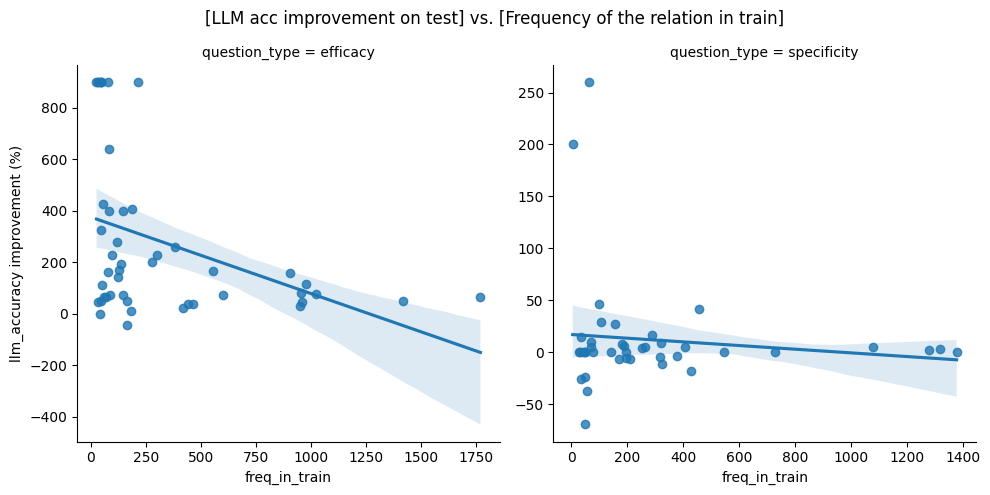

In [ ]:
sns.lmplot(
    data=diff_edit_df_described, 
    x="freq_in_train", y="llm_accuracy improvement (%)", 
    col="question_type", 
    order=1,
    facet_kws=dict(sharex=False, sharey=False),
)
plt.suptitle("[LLM acc improvement on test] vs. [Frequency of the relation in train]")
plt.subplots_adjust(top=0.87)

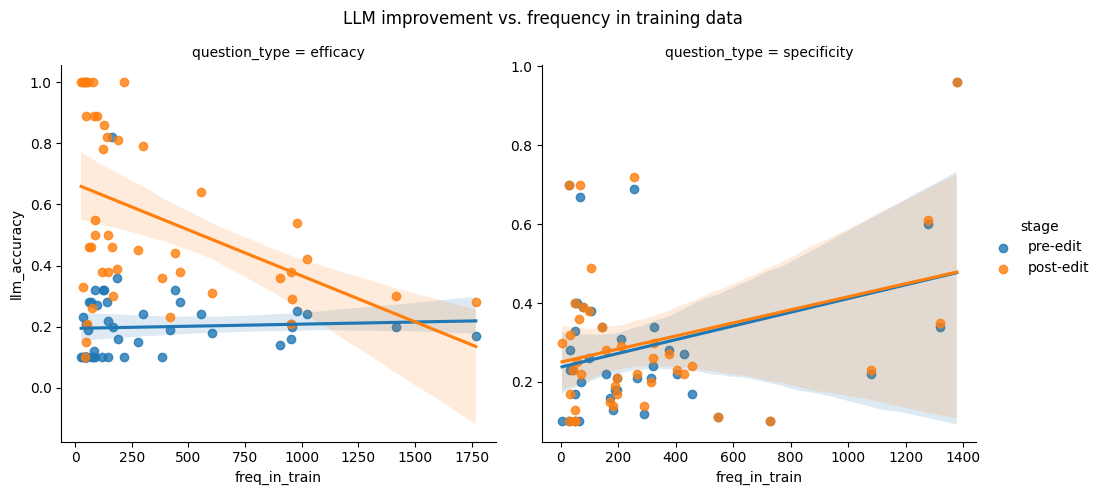

In [106]:
sns.lmplot(
    data=pd.concat([pre_edit_df_described, post_edit_df_described]), 
    x="freq_in_train", y="llm_accuracy", 
    col="question_type", 
    hue="stage",
    order=1,
    facet_kws=dict(sharex=False, sharey=False),
)
plt.suptitle("LLM improvement vs. frequency in training data")
plt.subplots_adjust(top=0.87)

In [ ]:
pre_edit_df["rel"] = pre_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
pre_edit_df["freq_in_train"] = pre_edit_df.apply(lambda x: count_rel[x.rel], axis=1)

/tmp/ipykernel_1230394/1062415260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_edit_df["rel"] = pre_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
/tmp/ipykernel_1230394/1062415260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_edit_df["freq_in_train"] = pre_edit_df.apply(lambda x: count_rel[x.rel], axis=1)


In [114]:
post_edit_df["rel"] = post_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
post_edit_df["freq_in_train"] = post_edit_df.apply(lambda x: count_rel[x.rel], axis=1)

/tmp/ipykernel_1230394/264467665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_edit_df["rel"] = post_edit_df.apply(lambda x: x.question_type + "::" + x.relation, axis=1)
/tmp/ipykernel_1230394/264467665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_edit_df["freq_in_train"] = post_edit_df.apply(lambda x: count_rel[x.rel], axis=1)


In [130]:
diff_edit_df = []

for i in range(len(pre_edit_df)):
    pre_row = pre_edit_df.iloc[i]
    post_row = post_edit_df.iloc[i]
    
    assert pre_row["rel"] == post_row["rel"]
    diff_row = deepcopy(post_row)
    diff_row["[A]|[Q] Acc EM"] = post_row["[A]|[Q] Acc EM"] - pre_row["[A]|[Q] Acc EM"]
    diff_row["[A]|[Q] Acc PM"] = post_row["[A]|[Q] Acc PM"] - pre_row["[A]|[Q] Acc PM"]
    diff_row["llm_accuracy improvement (%)"] = (post_row["llm_accuracy"] - pre_row["llm_accuracy"]) / pre_row["llm_accuracy"] * 100
    diff_edit_df.append(diff_row)
diff_edit_df = pd.DataFrame(diff_edit_df)
diff_edit_df["relation"] = diff_edit_df.apply(lambda x: x.relation + f"({count_rel[x.rel]})", axis=1)

In [131]:
# diff_edit_df.sort_values(by=["freq_in_train"], ascending=False)

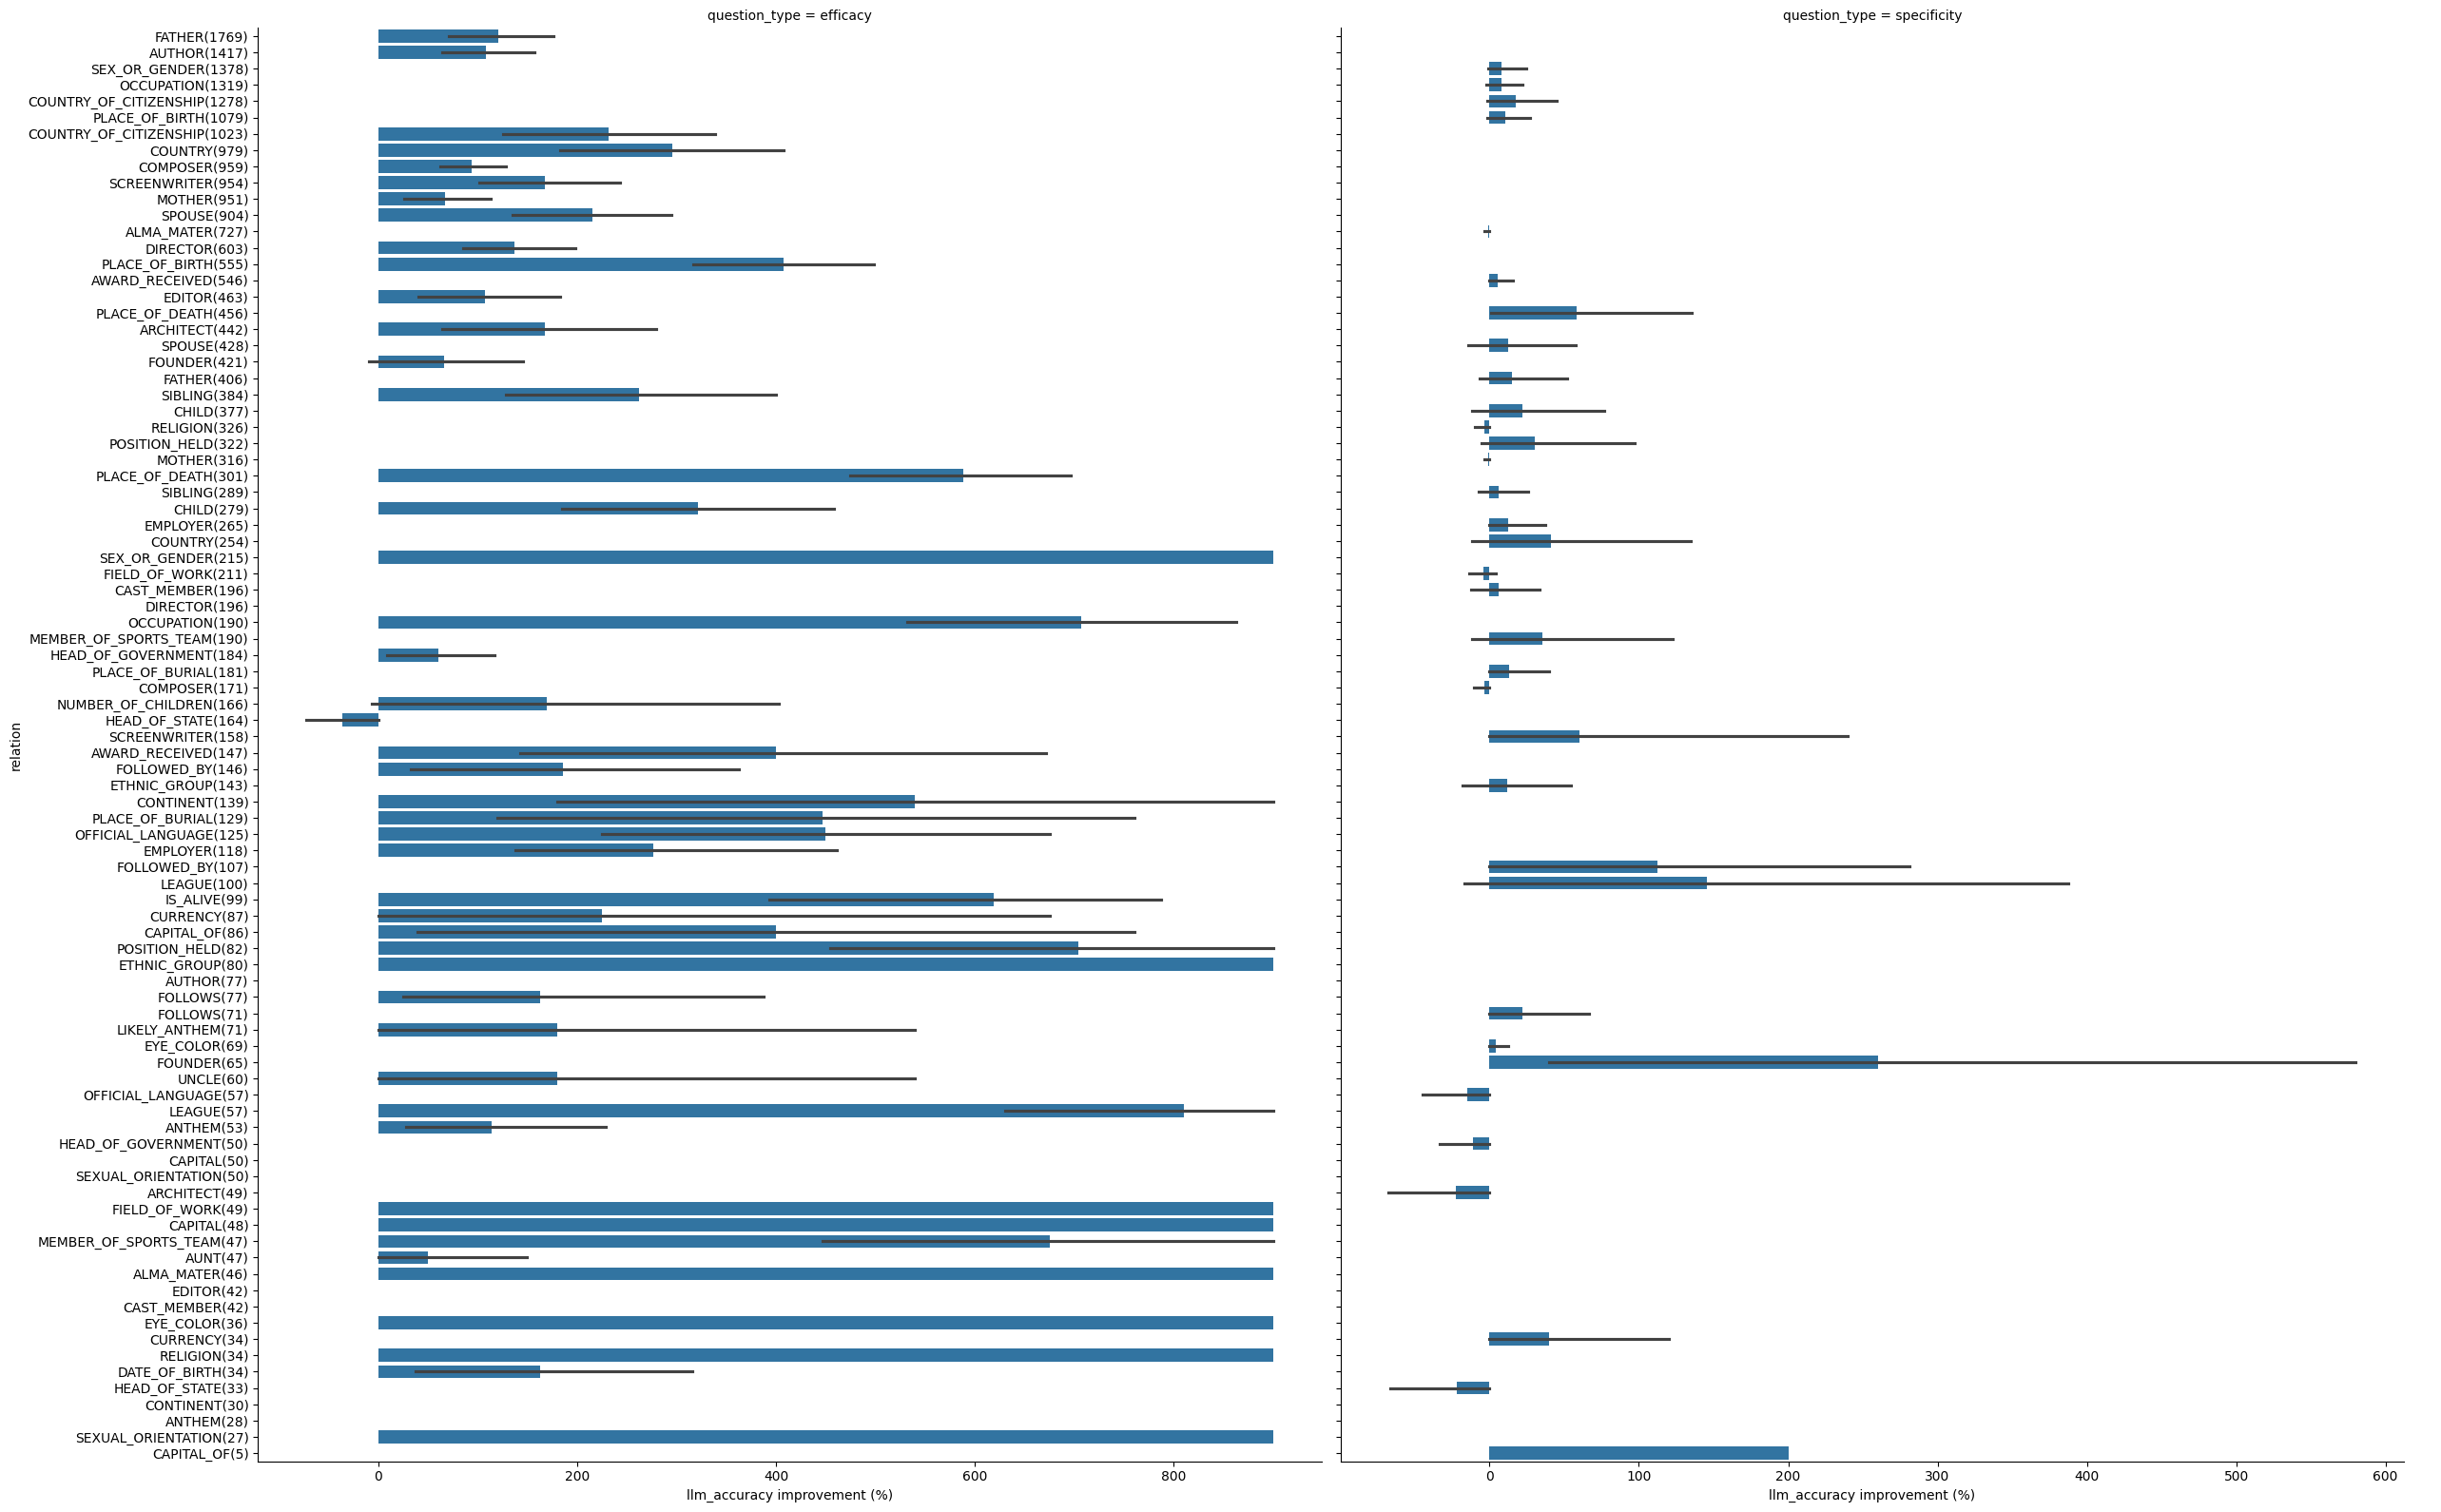

In [138]:
sns.catplot(
    diff_edit_df.sort_values(by=["freq_in_train"], ascending=False), 
    kind="bar",
    y="relation", x="llm_accuracy improvement (%)", 
    col="question_type",
    height=16, aspect=.8,
    sharex=False,
)

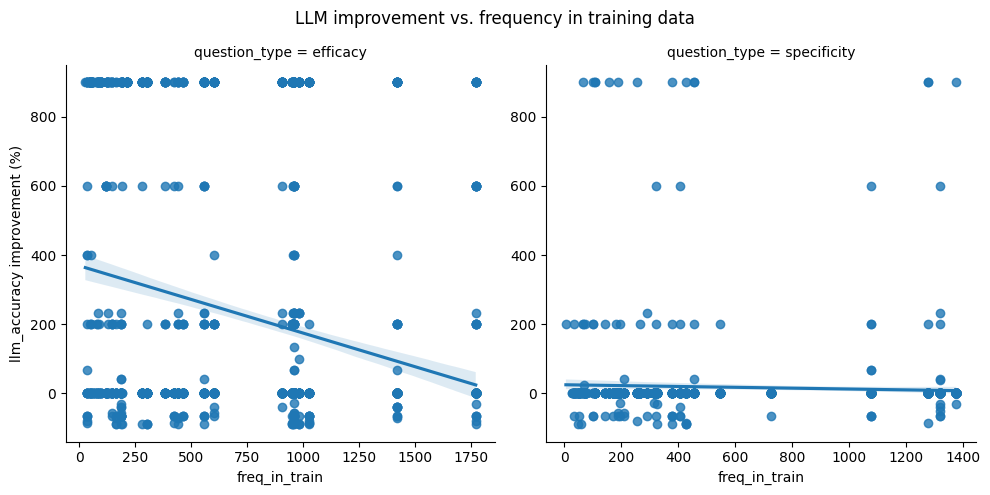

In [121]:
sns.lmplot(
    data=diff_edit_df, 
    x="freq_in_train", y="llm_accuracy improvement (%)", 
    col="question_type", 
    order=1,
    facet_kws=dict(sharex=False, sharey=False),
)
plt.suptitle("LLM improvement vs. frequency in training data")
plt.subplots_adjust(top=0.87)